# Simple Gaussian Mixture model

I put this together to illustrate to myself EM.

We have a simple model:

- some data (unimodal): x
- some latent variables (unimodal): z (which mean each data point is associated with)
- two parameters: the means of the k centres (m) and the mixing parameters (mix)

Note I've left out the variance as a parameter, and fixed it at one, just for simplicity.

In [24]:
import numpy as np

N = 10 #number of points
K = 2  #number of gaussians

x = np.hstack([np.random.randn(N/2)*1+2,np.random.randn(N/2)*1+8])
mu = np.random.randn(K)
mix = np.ones(K) / K*1.0
resp = np.zeros([N,K])

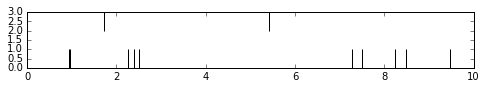

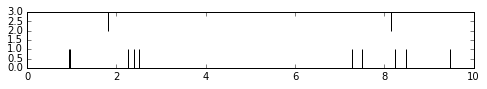

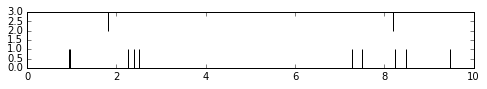

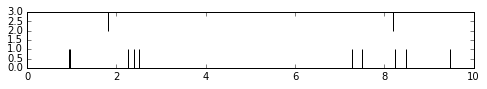

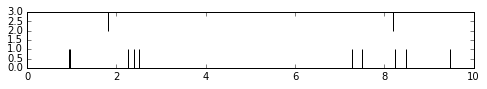

In [25]:
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

def eval_prob(x_v,mix_v,mu_v):
    p = mix_v * stats.norm.pdf(x_v,loc=mu_v,scale=1)
    return p

for it in range(5):
    #evaluate the responsibilities
    for n in range(N):
        for k in range(K):
            norm = 0
            for j in range(K):
                norm += eval_prob(x[n],mix[j],mu[j])
            resp[n,k] = eval_prob(x[n],mix[k],mu[k])/norm

    #maximise the closed form of the parameters...
    
        #mu_k = sum(resp * x)/sum(resp)

    for k in range(K):
        tot = 0
        tot_x = 0
        for n in range(N):
            tot_x += resp[n,k] * x[n]
            tot += resp[n,k]
        mu[k] = tot_x / tot #update mu

    
    plt.figure(figsize=(8, 1))
    plt.vlines(x,0,1)
    plt.vlines(mu,2,3)
    plt.ylim([0,3])
    

In [26]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
resp

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

## Expectation Maximisation for PCA

We have a prior over the latent variables $p(z) = N(z|0,I)$

We have a conditional distribution over the outputs $p(x|z) = N(x|Wz + \mu, \sigma^2 I)$

For the Expectation step...

1. We write $p(x,z) = p(x|z) p(z)$
2. $ln p(X,Z|\mu, W, \sigma^2) = \sum_n \left( ln p(x_n | z_n) p(z_n) \right)$ (we can do this summation because we assume each point is IID.
3. We want to know $E[ln p(X,Z | \mu, W, \sigma^2)] = E[\sum_n \left( ln p(x|z) + ln p(z) \right)]$
4. We expand out these distributions and apply the log to them, to get a long expression, importantly the values that are missing that we need are $E[z_n]$ and $E[z_n z_n^\top]$. We can find these from earlier work on PCA.

using $M = W^\top W + \sigma I$

we have this expression for $p(z|x)$:

$p(z|x) = N(z|M^{-1} W^\top (x-\mu), \sigma^2 M^{-1})$

This allows us to find the values for $E[z_n]$ and $E[z_n z_n^\top]$:

$E[z_n] = M^{-1} W^\top (x-\mu)$
$E[z_n z_n^\top] = \sigma^2 M^{-1}) + E[z_n]E[z_n]^\top$ (see identity proof at bottom of document)

For the Maximisation step...

We differentiated the epxression for $E[ln p(X,Z|\mu, W, \sigma^2)]$:

$W_{new} = \Big[\sum_n (x_n - \bar{x}) E[z_n]^\top\Big] \Big[\sum_n E[z_n z_n^\top] \Big]^{-1}$

$\sigma^2_{new} = ...$

In [27]:
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)


import numpy as np
Dn = 2
Mn = 2
N = 200
sigsqr = 1.0
#W = np.vstack([np.eye(Mn),np.zeros([Dn-Mn,Mn])]) #DxM
W = np.random.randn(Dn,Mn) * .001

x = np.random.randn(Dn,N)
x[1,:] += x[0,:]*1.5 #some covariance
x[0,:] = x[0,:] * 5.0
x[1,:] = x[1,:] * 2.0

x = x + np.random.randn(Dn,N) * .1

#x = np.random.multivariate_normal(np.zeros())
zeromean_x = (x.T - np.mean(x,1)).T #TODO Check subtraction is in the right direction.

print zeromean_x.shape
print x.shape #DxN

(2, 200)
(2, 200)


(-15, 15)

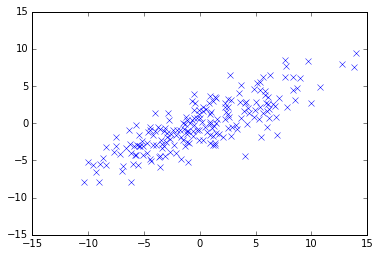

In [28]:
plt.plot(x[0,:],x[1,:],'x')
plt.xlim([-15,15])
plt.ylim([-15,15])

In [29]:


Ezz = []
Ez = []
new_Ezz = []
new_Ez = []
for n in range(N):
    Ezz.append(np.zeros([Mn,Mn]))
    Ez.append(np.zeros(Mn)[:,None])
    new_Ezz.append(np.zeros([Mn,Mn]))
    new_Ez.append(np.zeros(Mn))

sig_store = []
for it in range(100):
    #Expectation, find values of components...
    M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
    invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
    old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

    for n in range(N): #TODO: Vectorise
        new_Ez[n] = np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None] #MxD . Dx1 = Mx1
        new_Ezz[n] = sigsqr * invM + np.dot(new_Ez[n],new_Ez[n].T)
    #Maximisation 
    #Next We've differentiated E[ln p(X,Z|parameters)] and,
    #setting equal to zero, we can find what the parameters equal to maximise this
    Ez = new_Ez[:]
    Ezz = new_Ezz[:]
    
    partA = np.zeros([Dn,Mn])
    for n in range(N):
        partA += np.dot(zeromean_x[:,n][:,None],Ez[n].T)
        
    partB = np.zeros([Mn,Mn])
    for n in range(N):
        partB += Ezz[n]
    new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
    temp = 0
    for n in range(N):
        #np.linalg.norm() replace below
        temp += np.dot(zeromean_x[:,n],zeromean_x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),zeromean_x[:,n])
        temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
    new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

    sig_store.append(new_sigsqr)
   
    W = new_W.copy()
    sigsqr = new_sigsqr

print W
import matplotlib.pyplot as plt
%matplotlib inline

[[ 4.625835 -0.328561]
 [ 2.968822 -0.210868]]


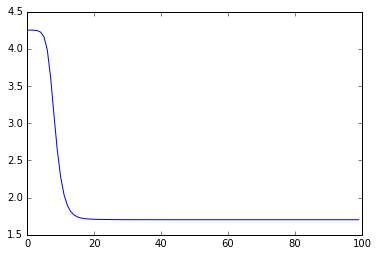

In [32]:
plt.plot(np.sqrt(sig_store))

In [33]:
np.sqrt(sigsqr)

array([ 1.702545])

In [34]:
W

array([[ 4.625835, -0.328561],
       [ 2.968822, -0.210868]])

In [35]:
a,b = np.linalg.eig(np.dot(x,x.T))
print b


[[ 0.841728 -0.539903]
 [ 0.539903  0.841728]]


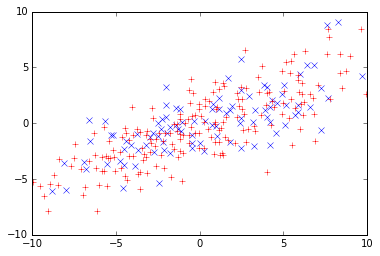

In [36]:
zs = np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn),100)
xpred = np.dot(W,zs.T) + np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn)*sigsqr,100).T
plt.plot(xpred[0,:],xpred[1,:],'x')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.plot(x[0,:],x[1,:],'+r')

In [132]:
zs.shape

(100, 2)

In [95]:
print np.dot(zeromean_x[0],zeromean_x[0])
print np.sum(zeromean_x[0]**2)

19533.0550174
19533.0550174


In [39]:
x[:,n]

array([ 0.064757, -0.560323,  0.656101,  0.943377,  0.616119])

In [40]:
cov = np.dot(zeromean_x,zeromean_x.T)
#cov = np.array([[2,1],[1,2]])
u,v,w = np.linalg.svd(cov)
print w
print W
normed_W = W / np.sqrt(np.sum(W**2,0))
print normed_W.T

[[-0.437257 -0.576872  0.446972  0.059578 -0.522198]
 [ 0.150452 -0.042414  0.43136  -0.867743  0.191092]
 [ 0.024424 -0.75346  -0.246581  0.05211   0.606782]
 [-0.017102 -0.173505 -0.730575 -0.461602 -0.472004]
 [-0.886161  0.260026 -0.140009 -0.166378  0.315945]]
[[ 0.539039  0.290173 -0.226545 -0.182221]
 [ 0.816748  0.354294 -0.064329 -0.07789 ]
 [-0.58053  -0.322487  0.195449 -0.32974 ]
 [ 0.012254 -0.045915  0.144265  0.756162]
 [ 0.588898  0.355201 -0.419885 -0.194912]]
[[ 0.420713  0.637461 -0.453096  0.009564  0.459627]
 [ 0.436462  0.53291  -0.485067 -0.069064  0.534273]
 [-0.42012  -0.119297  0.362455  0.267534 -0.778665]
 [-0.209329 -0.089478 -0.378793  0.868652 -0.223908]]


In [41]:
#print M
#print np.linalg.inv(M)
#print W
#print zeromean_x[:,0]
print sigsqr
print np.dot(W.T,W)
M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
invM = np.linalg.inv(M)

print np.dot(np.dot(np.linalg.inv(M),W.T),zeromean_x[:,0])
print old_Ez[0]
print Ez[0]
print np.dot(np.dot(invM,W.T),zeromean_x[:,0])

[ 0.065746]
[[ 1.641607  0.841611 -0.533623 -0.075934]
 [ 0.841611  0.441998 -0.307326 -0.078087]
 [-0.533623 -0.307326  0.290777  0.172772]
 [-0.075934 -0.078087  0.172772  0.757772]]
[-0.486457 -0.122341 -0.234444 -1.806129]
[[-0.476719]
 [-0.129937]
 [-0.228676]
 [-1.754779]]
[[-0.481226]
 [-0.127445]
 [-0.232339]
 [-1.782224]]
[-0.486457 -0.122341 -0.234444 -1.806129]


In [42]:
def sqrtm(m):
    u,l,v = np.linalg.svd(m)
    for x in range(m.shape[0]):
        for y in range(m.shape[1]):
            if np.abs(m[x,y]-m[y,x])>0.001:
                print m
                raise Exception("Not diagonal")
    return np.dot(u,np.diag(np.sqrt(l)))
    #return np.dot(np.dot(u,np.diag(np.sqrt(l))),np.linalg.inv(v))
    
a = np.array([[4,2,3],[2,8,1],[3,1,5]])
b = sqrtm(a)
print b
print np.dot(b,b.T)

[[-1.522377  0.928943 -0.905226]
 [-2.359487 -1.550749  0.16733 ]
 [-1.416288  1.584967  0.694267]]
[[ 4.  2.  3.]
 [ 2.  8.  1.]
 [ 3.  1.  5.]]


In [43]:
print np.linalg.det(cov)
U,l,w = np.linalg.svd(cov)
L = np.diag(l)
print np.dot(U,sqrtm(L-sigsqr*np.eye(Mn)))
print normed_W

7.26144554909e-15


ValueError: operands could not be broadcast together with shapes (5,5) (4,4) 

In [12]:
Ez[0]

array([[-0.      ],
       [-0.      ],
       [-0.000001],
       [ 0.000001]])

In [13]:
Ezz[0]

array([[ 1., -0., -0.,  0.],
       [-0.,  1., -0.,  0.],
       [-0., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

### Identity $E[(a+\mu)(a+\mu)^\top] = cov(a) + \mu \mu^\top$

The final term above comes from this identity:

$E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + E[a \mu^\top] + E[\mu a^\top] + E[\mu \mu^\top]$ 

We note that $E[\mu \mu^\top]=\mu \mu^\top$
and
$E[a \mu^\top]= E[a] \mu ^\top = 0$. 

Leaving just: $E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + \mu \mu^\top = cov(a) + \mu \mu^\top$



In [44]:
(W/np.sqrt(np.sum(W**2,1))).T

ValueError: operands could not be broadcast together with shapes (5,4) (5,) 

In [45]:
W

array([[ 0.539039,  0.290173, -0.226545, -0.182221],
       [ 0.816748,  0.354294, -0.064329, -0.07789 ],
       [-0.58053 , -0.322487,  0.195449, -0.32974 ],
       [ 0.012254, -0.045915,  0.144265,  0.756162],
       [ 0.588898,  0.355201, -0.419885, -0.194912]])

In [46]:
np.rank(W)

/home/lionfish/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


2

In [413]:
zeromean_x

array([[ 1.991,  0.052,  0.373, -1.241, -1.174],
       [-0.75 ,  0.882,  0.016, -0.708,  0.56 ]])

In [414]:
Ez

[array([[-0.15 ],
        [-0.381]]), array([[ 0.012],
        [ 0.027]]), array([[-0.025],
        [-0.065]]), array([[ 0.073],
        [ 0.189]]), array([[ 0.091],
        [ 0.229]])]